# Horizontal Scaling via Spatial Chunking

## Overview

OCR uses a spatial chunking system that enables embarrassingly parallel processing of large-scale CONUS fire risk datasets at 30m resolution. Similar to the serverless approach described in ["A Serverless Approach to Building Planetary-Scale EO Datacubes"](https://earthmover.io/blog/serverless-datacube-pipeline), our system breaks down the complete CONUS dataset into manageable, independently processable regions.

This approach provides several key advantages:

- **Parallelization**: Process hundreds of regions simultaneously across distributed compute resources
- **Fault tolerance**: Failed regions can be reprocessed independently without affecting others
- **Resource efficiency**: Match chunk sizes to available memory and compute resources
- **Incremental processing**: Process and commit regions as they complete, enabling progress tracking

## Core Concepts

The spatial chunking system is built around the `ChunkingConfig` class, which provides:

1. **Chunk definition and layout**: Defines the spatial grid dividing CONUS into processable regions
2. **Spatial indexing**: Rapidly identifies chunks intersecting with regions of interest
3. **Coordinate transformations**: Converts between pixel indices, geographic coordinates, and chunk IDs
4. **Visualization capabilities**: Displays chunk layouts and spatial relationships

### Architecture

```mermaid
graph TB
    A[CONUS 30m Dataset] --> B[ChunkingConfig]
    B --> C[Spatial Grid Definition]
    B --> D[Coordinate System]
    B --> E[Region ID Mapping]
    
    C --> F[595 Processing Regions]
    D --> G[EPSG:4326 Transform]
    E --> H[Region ID ↔ Chunk ID ↔ Lat/Lon Slices]
    
    F --> I[Parallel Processing]
    G --> I
    H --> I
    
    I --> J[Region 0: y0_x0]
    I --> K[Region 1: y0_x1]
    I --> L[Region N: yM_xN]
    
    J --> M[Icechunk Store]
    K --> M
    L --> M
    
    style A fill:#e1f5ff
    style M fill:#ffe1e1
    style I fill:#fff4e1
```

## Chunking Configuration

Let's explore the chunking configuration using the `ChunkingConfig` class.

In [1]:
from ocr.config import ChunkingConfig

config = ChunkingConfig(debug=True)
config

<POLYGON ((-64.054 22.428, -64.054 52.482, -128.387 52.482, -128.387 22.428,...>

### Template Dataset

The chunking system uses the `USFS-wildfire-risk-communities-4326` dataset as a template to establish the spatial reference framework:

| Property | Value |
|----------|-------|
| **Resolution** | 30m (~0.0002778°) |
| **Projection** | EPSG:4326 (WGS84) |
| **Total Chunks** | 595 regions |
| **Chunk Size** | 6000 × 4500 pixels |
| **Dimensions** | latitude × longitude |

`ChunkingConfig` uses this dataset as a template to compute properties (e.g. CONUS bounds, `transform`, chunk information) that are used to convert between chunk IDs and spatial bounds.

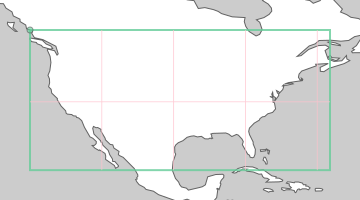

In [2]:
config.ds.odc.geobox

### Coordinate System

The system maintains an affine transformation matrix that enables bidirectional conversion between:

- **Pixel indices** (array coordinates)
- **Geographic coordinates** (EPSG:4326 longitude/latitude)
- **Chunk IDs** (region identifiers)

This transformation is crucial for:
- Converting bounding boxes to chunk selections
- Extracting geographic extents from pixel regions
- Validating spatial queries and data alignment

## Visualizing the Chunking System

### All Chunks Layout

The `.plot_all_chunks()` method allows us to visualize the grid layout of our zarr/dask chunks and how they align with the CONUS geography.

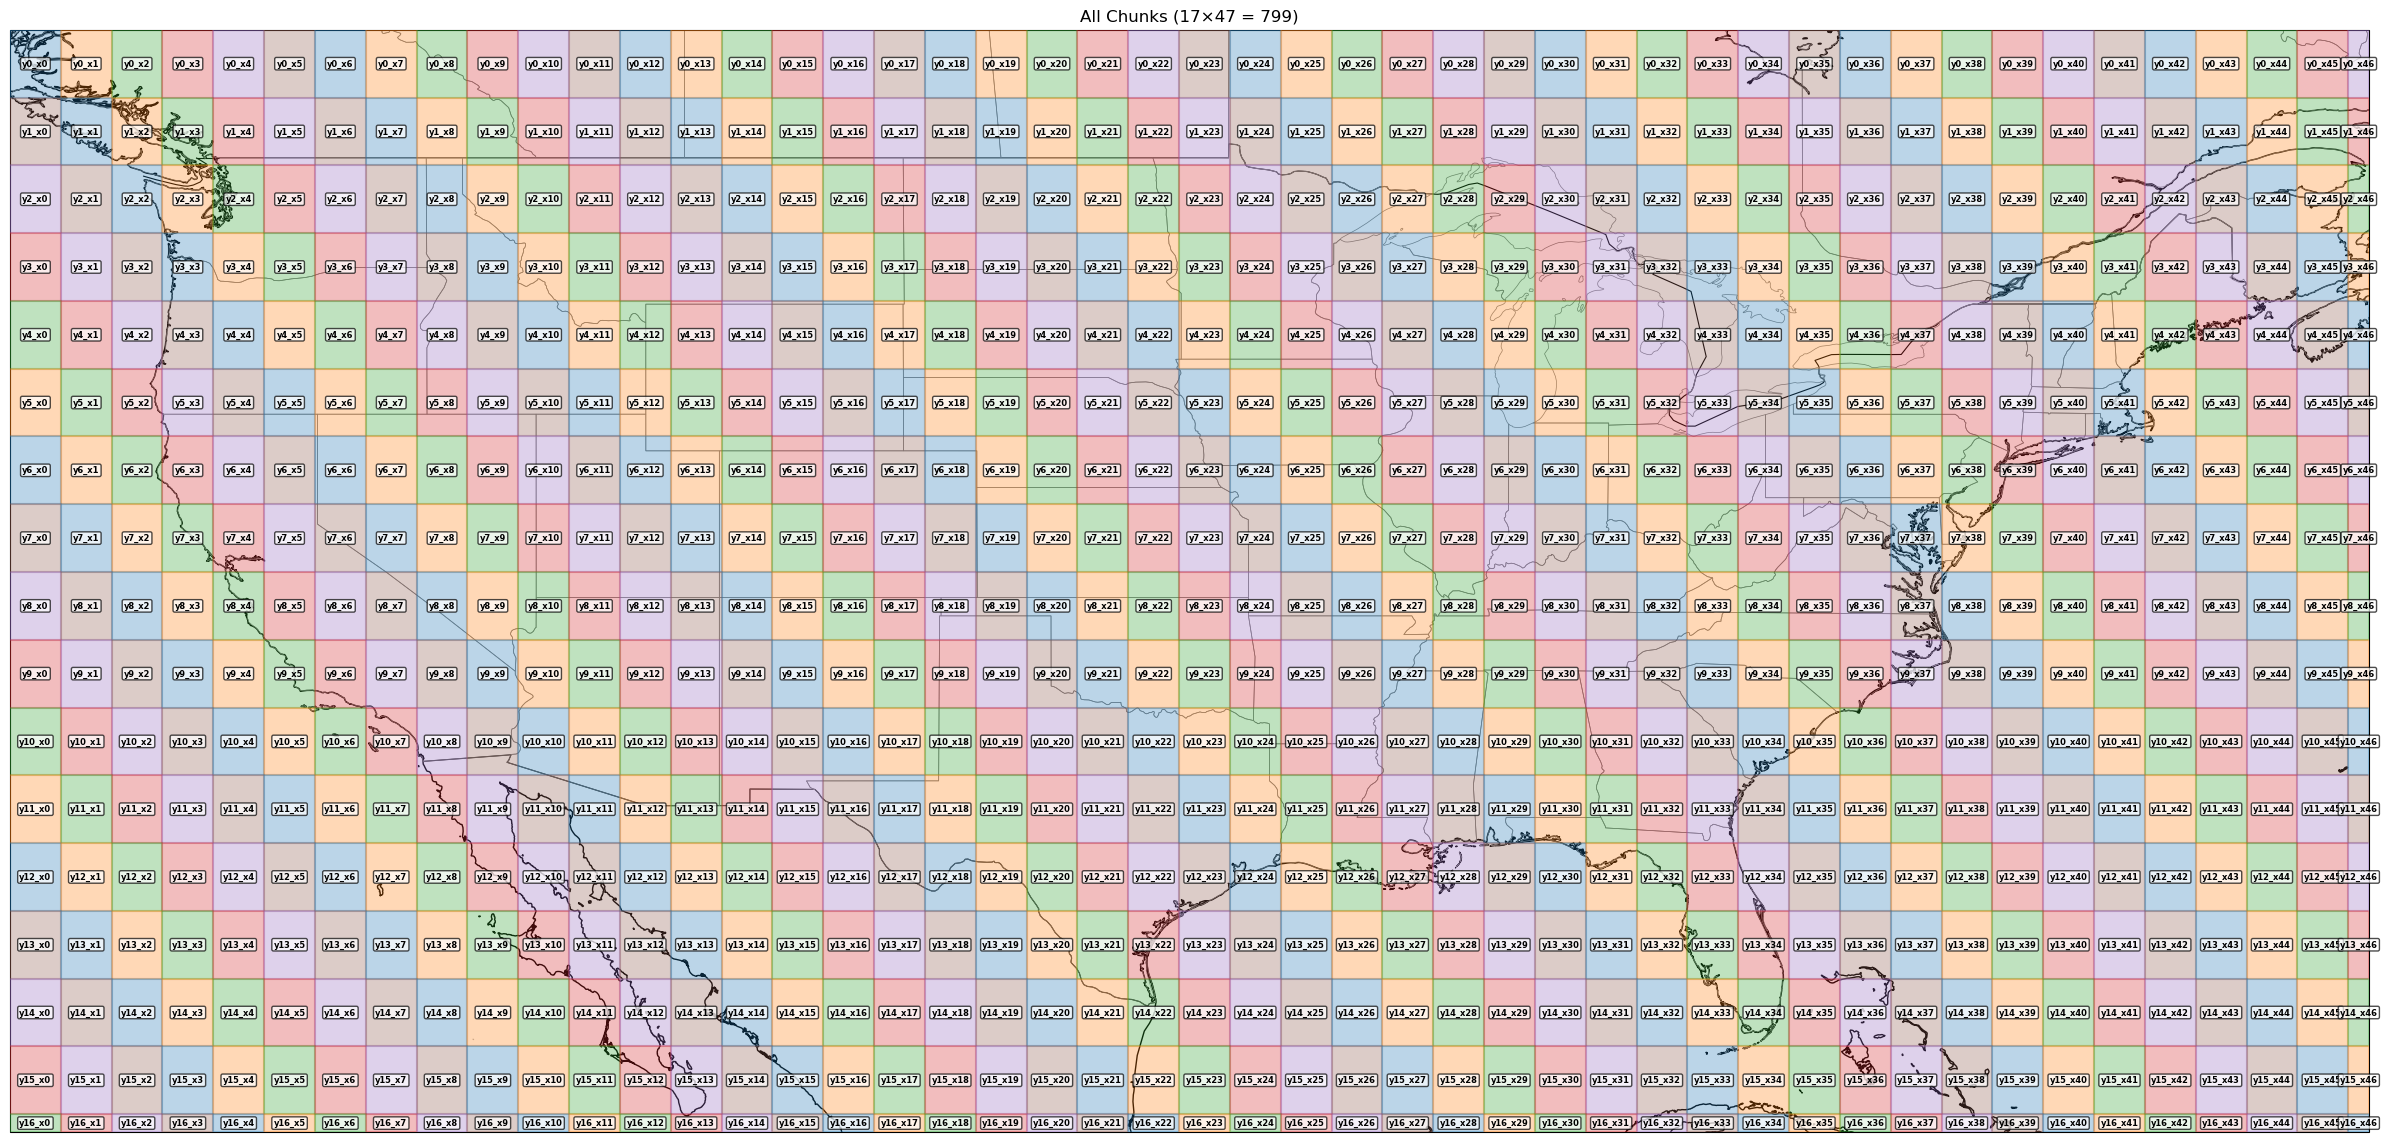

In [3]:
config.plot_all_chunks()

In the plot above, we can see the chunk layout of the `USFS-wildfire-risk-communities` dataset. The dataset has 595 chunks, each with size (6000, 4500). The chunks are arranged in a grid layout, with each chunk covering a specific geographic area.

Let's examine the dataset structure and verify the number of chunks:

In [4]:
config.ds

<xarray.Dataset> Size: 82GB
Dimensions:      (latitude: 97579, longitude: 208881)
Coordinates:
  * latitude     (latitude) float64 781kB 52.48 52.48 52.48 ... 22.43 22.43
  * longitude    (longitude) float64 2MB -128.4 -128.4 -128.4 ... -64.05 -64.05
    spatial_ref  int32 4B 4326
Data variables:
    CRPS         (latitude, longitude) float32 82GB dask.array<chunksize=(6000, 4500), meta=np.ndarray>
Attributes:
    title:        RDS-2020-0016-02
    version:      2024-V2
    data_source:  https://www.fs.usda.gov/rds/archive/catalog/RDS-2020-0016-
    description:  ['Modified version of: Wildfire Risk to Communities: Spatia...
    EPSG:         4326
    resolution:   30m

In [5]:
print(f'Number of dask/zarr chunks: {config.ds.CRPS.data.npartitions}')

Number of dask/zarr chunks: 799


## Region Identification System

### Region ID Format

Each processing region is identified by a unique string ID:

```text
y{iy}_x{ix}
```

Where:
- `iy`: Index along the y-dimension (latitude), ranging from 0 to number of y-chunks - 1
- `ix`: Index along the x-dimension (longitude), ranging from 0 to number of x-chunks - 1

**Example**: `y5_x14` refers to the chunk at row 5, column 14 of the spatial grid.

### Region ID Lookup Process

```mermaid
flowchart LR
    A[Region ID<br/>y5_x14] --> B[Chunk Index<br/>iy=5, ix=14]
    B --> C[Pixel Slices<br/>y: 30000-36000<br/>x: 85500-90000]
    C --> D[Geographic Bounds<br/>lat: 38.5° - 40.2°<br/>lon: -102.5° - -100.3°]
    
    style A fill:#e1f5ff
    style D fill:#ffe1e1
```

### Valid Region Filtering

Not all regions in the grid contain valid data. The system maintains a list of valid region IDs that:
- Contain non-null data (not entirely ocean or outside CONUS)
- Have been precomputed to avoid processing empty regions
- Are checked during pipeline execution to skip invalid regions

## Spatial Indexing

### Bounding Box Queries

The chunking system can efficiently identify which chunks intersect with arbitrary geographic bounding boxes. Let's demonstrate this with several U.S. states:

We've defined bounding boxes for three different regions:
- Colorado (co_bbox): A rectangular region covering the state of Colorado
- California (ca_bbox): A rectangular region covering the state of California
- Arkansas (ar_bbox): A rectangular region covering the state of Arkansas

In [6]:
co_bbox = config.bbox_from_wgs84(-109.059196, 36.992751, -102.042126, 41.001982)
ca_bbox = config.bbox_from_wgs84(
    -124.41060660766607, 32.5342307609976, -114.13445790587905, 42.00965914828148
)
ar_bbox = config.bbox_from_wgs84(
    -94.61946646626465, 33.00413641175411, -89.65547287402873, 36.49965029279292
)

In [7]:
# Let's display the bounding boxes to see their coordinates
print('Colorado bbox:', co_bbox)
print('California bbox:', ca_bbox)
print('Arkansas bbox:', ar_bbox)

Colorado bbox: POLYGON ((-102.042126 36.992751, -102.042126 41.001982, -109.059196 41.001982, -109.059196 36.992751, -102.042126 36.992751))
California bbox: POLYGON ((-114.13445790587905 32.5342307609976, -114.13445790587905 42.00965914828148, -124.41060660766607 42.00965914828148, -124.41060660766607 32.5342307609976, -114.13445790587905 32.5342307609976))
Arkansas bbox: POLYGON ((-89.65547287402873 33.00413641175411, -89.65547287402873 36.49965029279292, -94.61946646626465 36.49965029279292, -94.61946646626465 33.00413641175411, -89.65547287402873 33.00413641175411))


### Spatial Query Workflow

```mermaid
sequenceDiagram
    participant User
    participant Config as ChunkingConfig
    participant Index as Spatial Index
    participant Store as Data Store
    
    User->>Config: bbox_from_wgs84(lon, lat bounds)
    Config->>Index: Compute intersecting chunks
    Index->>Index: Transform bounds to pixel space
    Index->>Index: Identify overlapping chunks
    Index-->>Config: Return chunk IDs
    Config-->>User: ['y7_x12', 'y8_x13', ...]
    
    User->>Store: Process only selected chunks
    Store-->>User: Targeted results
```

The next cell will:

1. Identify all chunks that intersect with each bounding box using `get_chunks_for_bbox()`
2. Visualize these chunks on the CONUS map to demonstrate how our chunking system can efficiently select only the data chunks needed for specific geographic regions

This illustrates a key advantage of the spatial chunking system; rather than processing the entire CONUS dataset, we can quickly identify and process only the chunks that contain our regions of interest. This is particularly useful for:

- **Targeted processing**: Only compute regions of interest
- **Debugging workflows**: Re-run specific geographic areas
- **Incremental updates**: Process new regions without reprocessing everything

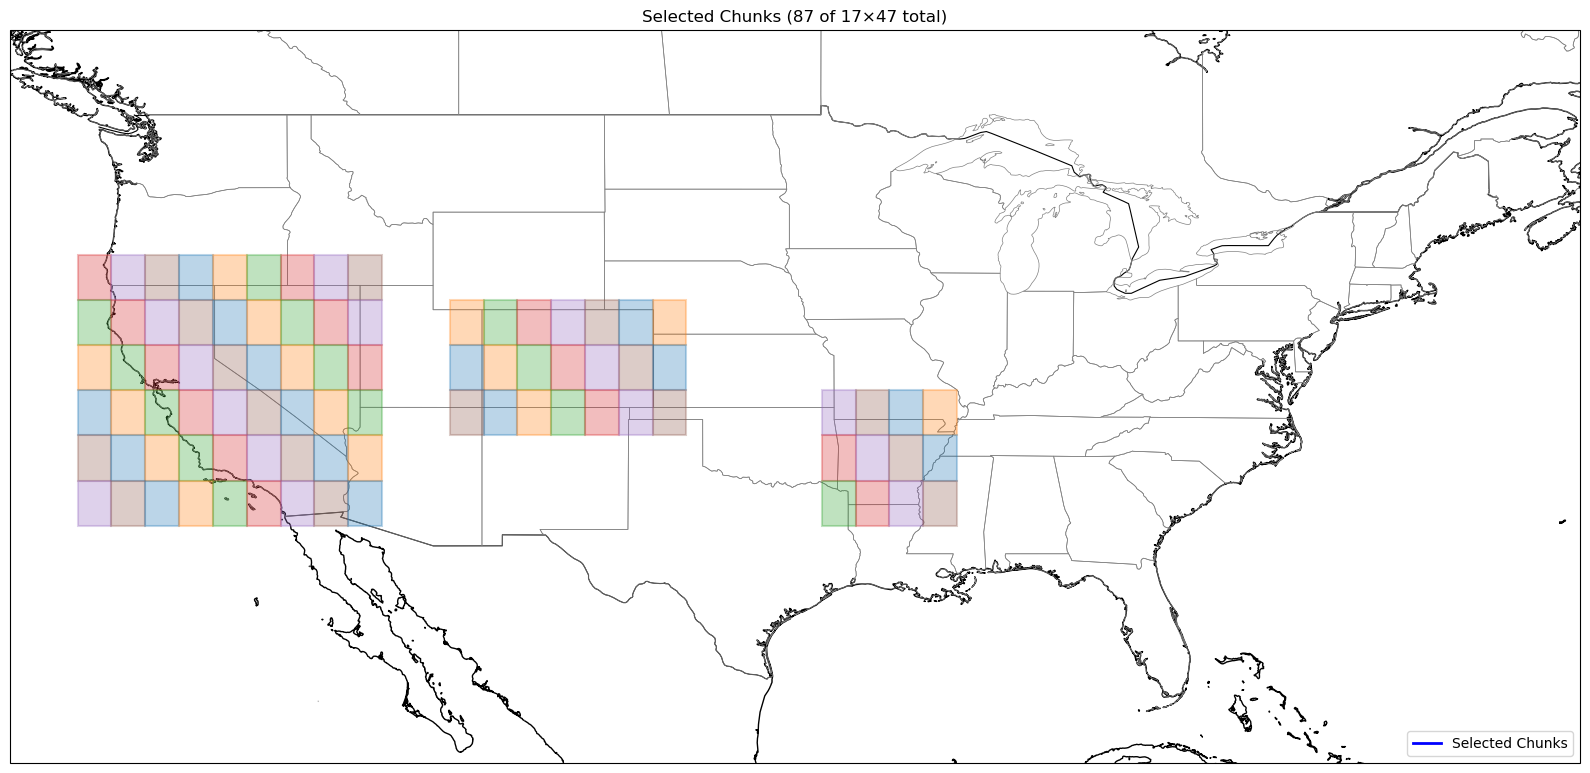

In [8]:
co_chunks = config.get_chunks_for_bbox(co_bbox)
ca_chunks = config.get_chunks_for_bbox(ca_bbox)
ar_chunks = config.get_chunks_for_bbox(ar_bbox)
config.visualize_chunks_on_conus(chunks=ca_chunks + co_chunks + ar_chunks)

### Fine-Grained Spatial Queries

In the cell below, we identify the chunks that intersect with the Eaton fire in California, demonstrating the system's ability to work at very fine spatial scales.

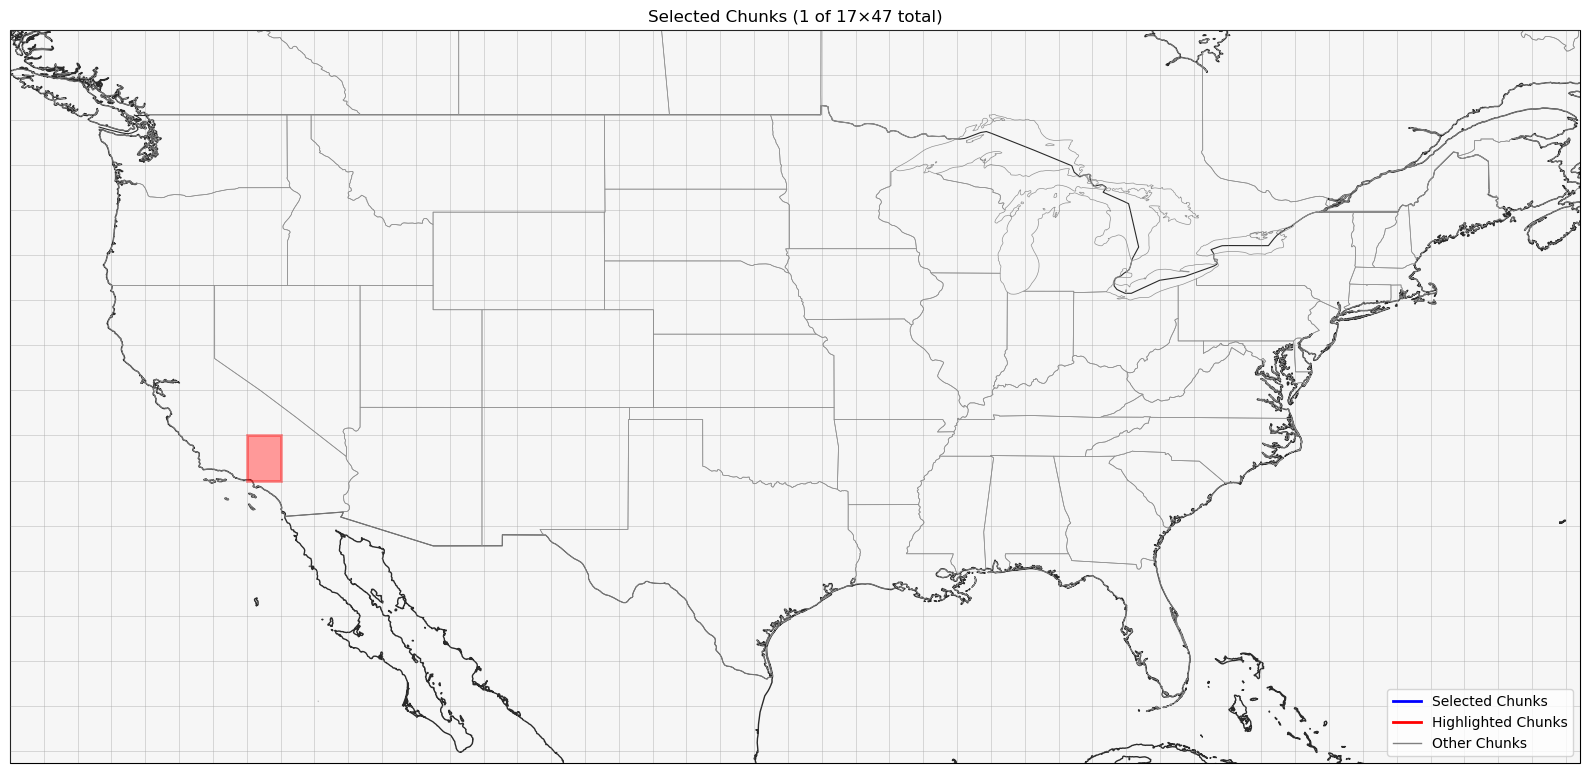

In [11]:
eaton_fire_bbox = config.bbox_from_wgs84(
    -118.16359507363843, 34.1609756217009, -118.01833468855428, 34.23216929604394
)
eaton_fire_chunks = config.get_chunks_for_bbox(eaton_fire_bbox)
config.visualize_chunks_on_conus(
    eaton_fire_chunks, highlight_chunks=eaton_fire_chunks, include_all_chunks=True
)

## Parallel Processing Framework

### Processing Pipeline

Like the serverless approach described in the blog post, our system enables embarrassingly parallel processing of chunks.

```mermaid
graph TB
    subgraph "Input"
        A[Valid Region IDs]
    end
    
    subgraph "Orchestration"
        B[Task Scheduler<br/>Coiled/Dask]
    end
    
    subgraph "Parallel Workers"
        C1[Worker 1<br/>Region y0_x5]
        C2[Worker 2<br/>Region y1_x8]
        C3[Worker 3<br/>Region y2_x12]
        CN[Worker N<br/>Region yM_xN]
    end
    
    subgraph "Processing"
        D1[Calculate Risk<br/>Region y0_x5]
        D2[Calculate Risk<br/>Region y1_x8]
        D3[Calculate Risk<br/>Region y2_x12]
        DN[Calculate Risk<br/>Region yM_xN]
    end
    
    subgraph "Storage"
        E1[Commit to Icechunk<br/>Region y0_x5]
        E2[Commit to Icechunk<br/>Region y1_x8]
        E3[Commit to Icechunk<br/>Region y2_x12]
        EN[Commit to Icechunk<br/>Region yM_xN]
    end
    
    subgraph "Output"
        G[Icechunk Store<br/>Raster Data]
        H[GeoParquet Files<br/>Vector Data]
    end
    
    A --> B
    B --> C1 & C2 & C3 & CN
    C1 --> D1 --> E1
    C2 --> D2 --> E2
    C3 --> D3 --> E3
    CN --> DN --> EN
    E1 & E2 & E3 & EN --> G
    E1 & E2 & E3 & EN --> H
    
    style A fill:#e1f5ff
    style B fill:#fff4e1
    style G fill:#ffe1e1
    style H fill:#ffe1e1
```

This means that we can:

- Create a template zarr store for the entire CONUS dataset
- Each worker processes its assigned region independently and writes its own data directly to Icechunk
- Because our chunking system ensures that chunks are aligned with the CONUS geography, we can use xarray's `to_zarr(region='auto')` method to automatically determine the region for each chunk
- Each worker creates its own commit for the region it processed, enabling parallel writes without conflicts

### Implementation Pattern

Below is an example of how this might look in practice:

```python
def process_region(region_id: str, config: OCRConfig):
    """Process a single region independently"""
    # 1. Get spatial bounds for this region
    y_slice, x_slice = config.chunking.region_id_to_latlon_slices(region_id)
    
    # 2. Calculate wind-adjusted risk for this region
    ds = calculate_wind_adjusted_risk(y_slice=y_slice, x_slice=x_slice)
    
    # 3. Each worker writes its own data to Icechunk with automatic region detection
    config.icechunk.insert_region_uncooperative(ds, region_id=region_id)
    
    # 4. Sample buildings and write vector data
    buildings_gdf = sample_risk_to_buildings(ds=ds)
    buildings_gdf.to_parquet(f'{region_id}.parquet')
    
    return region_id

# Execute in parallel across all valid regions
# Each worker independently processes and writes its region
results = []
for region_id in config.chunking.valid_region_ids:
    result = process_region(region_id, config)
    results.append(result)
```

### Key Features

| Feature | Description |
|---------|-------------|
| **Independence** | Each region processes without dependencies on others |
| **Parallel Writes** | Each worker writes its own region data directly to Icechunk |
| **Idempotency** | Regions can be reprocessed safely; commits track completion |
| **Scalability** | Add more workers to process more regions simultaneously |
| **Progress Tracking** | Each worker's commit logs the completed region for restart capability |
| **Error Isolation** | Failed regions don't affect successful ones |

## Integration with Storage

### Icechunk Store

The chunking system integrates seamlessly with Icechunk for raster data:

- **Aligned chunks**: Zarr chunks match processing region boundaries
- **Region-based commits**: Each processed region generates a commit
- **Automatic region detection**: `to_zarr(region='auto')` uses chunk alignment
- **Progress tracking**: Commit ancestry shows which regions are complete

```python
# Template creation with aligned chunks
template = xr.Dataset(coords).chunk({
    'latitude': config.chunks['latitude'],   # 6000
    'longitude': config.chunks['longitude']   # 4500
})
```

### Vector Data Organization

Vector data (building samples) follows the same regional organization:

- **Per-region files**: `{region_id}.parquet` during processing
- **Consolidated output**: Aggregated into single CONUS-wide GeoParquet
- **Spatial indexing**: Bounding boxes enable efficient spatial queries

## Best Practices

### Region Selection

1. **Validate region IDs**: Always check against `valid_region_ids` before processing
2. **Check processed status**: Skip already-completed regions to avoid duplicate work
3. **Use spatial queries**: When debugging, target specific geographic areas

### Processing Configuration

1. **Match chunk size to memory**: Ensure workers have sufficient RAM for chunk size
2. **Monitor progress**: Track commit messages to verify completion
3. **Handle edge cases**: Smaller chunks near CONUS boundaries may need special handling

### Debugging Workflow

1. **Visualize target area**: Use `visualize_chunks_on_conus()` to identify relevant chunks
2. **Process subset**: Test on 2-3 chunks before full CONUS run
3. **Verify outputs**: Check both Icechunk commits and GeoParquet files

## Summary

This notebook has demonstrated OCR's spatial chunking system for horizontal scaling of fire risk computations:

- **Architecture**: How the chunking system divides CONUS into 595 independently processable regions
- **Region identification**: The `y{iy}_x{ix}` naming convention and coordinate transformations
- **Spatial indexing**: Efficiently finding chunks for specific geographic areas
- **Parallel processing**: Processing regions independently with fault tolerance
- **Storage integration**: How chunks align with Icechunk and GeoParquet outputs
- **Performance**: Expected throughput and resource requirements

This system enables efficient, scalable processing of 30m resolution CONUS-wide fire risk datasets through embarrassingly parallel computation.

## Fault Tolerance

### Restart Capability

The system tracks processed regions via Icechunk commit messages:

```python
# Check which regions are already processed
processed = config.icechunk.processed_regions()

# Filter to unprocessed regions only
status = config.select_region_ids(
    region_ids=all_valid_regions,
    all_region_ids=True
)
to_process = status.unprocessed_valid_region_ids

# Resume processing from where it left off
for region_id in to_process:
    process_region(region_id, config)
```

### Error Handling

```mermaid
flowchart TD
    A[Start Processing Region] --> B{Region Valid?}
    B -->|No| C[Skip]
    B -->|Yes| D{Already Processed?}
    D -->|Yes| E[Skip]
    D -->|No| F[Process Region]
    F --> G{Success?}
    G -->|Yes| H[Commit to Store]
    G -->|No| I[Log Error]
    I --> J[Continue to Next Region]
    H --> K[Update Progress]
    
    style C fill:#ffd4d4
    style E fill:#fff4d4
    style H fill:#d4ffd4
    style I fill:#ffd4d4
```

Benefits:

- **Partial completion**: Successfully processed regions persist even if others fail
- **Retry logic**: Failed regions can be identified and reprocessed
- **No cascading failures**: One region's error doesn't affect others

## Performance Characteristics

### Scalability Metrics

| Metric | Value |
|--------|-------|
| **Total Regions** | 595 valid regions |
| **Typical Region Size** | 6000 × 4500 pixels (~27M pixels) |
| **Memory per Region** | ~500 MB - 2 GB (depending on variables) |
| **Processing Time** | ~2-5 minutes per region (varies by computation) |
| **Parallelization** | Limited only by available compute resources |


## Related Documentation

-   [Data Schema](../../reference/data-schema.md): Structure of output datasets
-   [Deployment](../../reference/deployment.md): Infrastructure for distributed processing

